In [1]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas
import matplotlib.pyplot as plt
import time
import pickle
from shapely.geometry import Point, Polygon

%matplotlib inline
width = 40
height = 40
plt.rcParams['figure.figsize'] = [width, height]

pd.options.display.max_columns = None

## Check if geopandas is installed
## import sys
## 'geopandas' in sys.modules

# Merge ICS 209 Plus Dataset to MTBS
# Assign ICS fires (not complexes) to appropriate MTBS perimeter
# Match ICS complex fires to MTBS perimeters

## Set Directory
path = '/data/yoder/DensityProject/'
os.chdir(path)
# os.listdir()

In [2]:
# import dask
# import dask.distributed
# import dask.dataframe as dd
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster( cores =20 , memory = '256GB', walltime = '1-23:00:00') #, queue ='cahnrs')

# cluster.scale(4)
# # cluster.adapt(minimum=0, maximum=20) 


# from dask.distributed import Client

# client = Client(cluster)
# # cluster.scale(jobs = 2)
# client

In [3]:
# from dask import persist

In [4]:
# cluster.scale(15)

In [5]:
# client

In [6]:
# Load map of US
USMAP = geopandas.read_file(path + '/cb_2018_us_state_500k.shp')

# Read in MTBS Data
MTBS = geopandas.read_file(path + '/mtbs_perimeter_data/mtbs_perims_DD.shp')

## Check CRS
# print(USMAP.crs == MTBS.crs)
# USMAP.crs

# Create set of the 11 Western United States
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

## Plot MTBS data
# basemap = WestStates.plot(color = 'white', edgecolor = 'black')
# MTBS.plot(ax=basemap, color = 'red')

## Prepare to merge with ICS 209
mapcols = WestStates.columns.tolist()
mapcols_to_drop = [col for col in mapcols if col !='geometry']

## Dissolve borders within Western US
WestStates.loc[WestStates['STUSPS'].isin(West), 'Is_west'] = 1
dissolved_west = WestStates.dissolve(by='Is_west')
dissolved_west = dissolved_west.drop(mapcols_to_drop, axis=1).copy()

# Select only fire perimeters entirely within western US
West_MTBS = geopandas.sjoin(MTBS, dissolved_west, op='within')
West_MTBS = West_MTBS.drop(['index_right'], axis = 1)



/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
# ## Plot to check border fires (only want fires completly within states)

# # Create West sample based on MTBS location naming
# West_MTBS_sat = MTBS.loc[MTBS['Fire_ID'].str[0:2].isin(West)]

# # Fires in red are not included in study since they are not completely contained in the Western US
# basemap = WestStates.plot(edgecolor='black', color='white')
# West_MTBS_sat.plot(ax=basemap,color='red')
# West_MTBS.plot(ax=basemap,color='blue')

In [8]:
# Read in 209 Data
ICS_209_inci = pd.read_csv(path + '/ics209-plus-wildfire/ics209-plus-wf_incidents_1999to2014.csv')
# ICS_209_inci.head(2)

# Create GeoDataFrame from ICS data
ICS = geopandas.GeoDataFrame(ICS_209_inci, geometry=geopandas.points_from_xy(ICS_209_inci.POO_LONGITUDE , ICS_209_inci.POO_LATITUDE))

## Assign crs to ICS data
ICS.crs="epsg:4269"

# ICS.crs

# Select ICS forms for 11 Western United States (10319 fires)
WestICS = ICS[ICS['POO_STATE'].isin(West)].copy()

# Creat Dataset with MTBS and ICS
ICBS = pd.merge(West_MTBS, WestICS, left_on='Fire_ID', right_on='MTBS_ID', suffixes =('_from_MTBS','_from_ICS'))
# ICBS.head(2)

/opt/apps/anaconda3/20.02.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,13,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


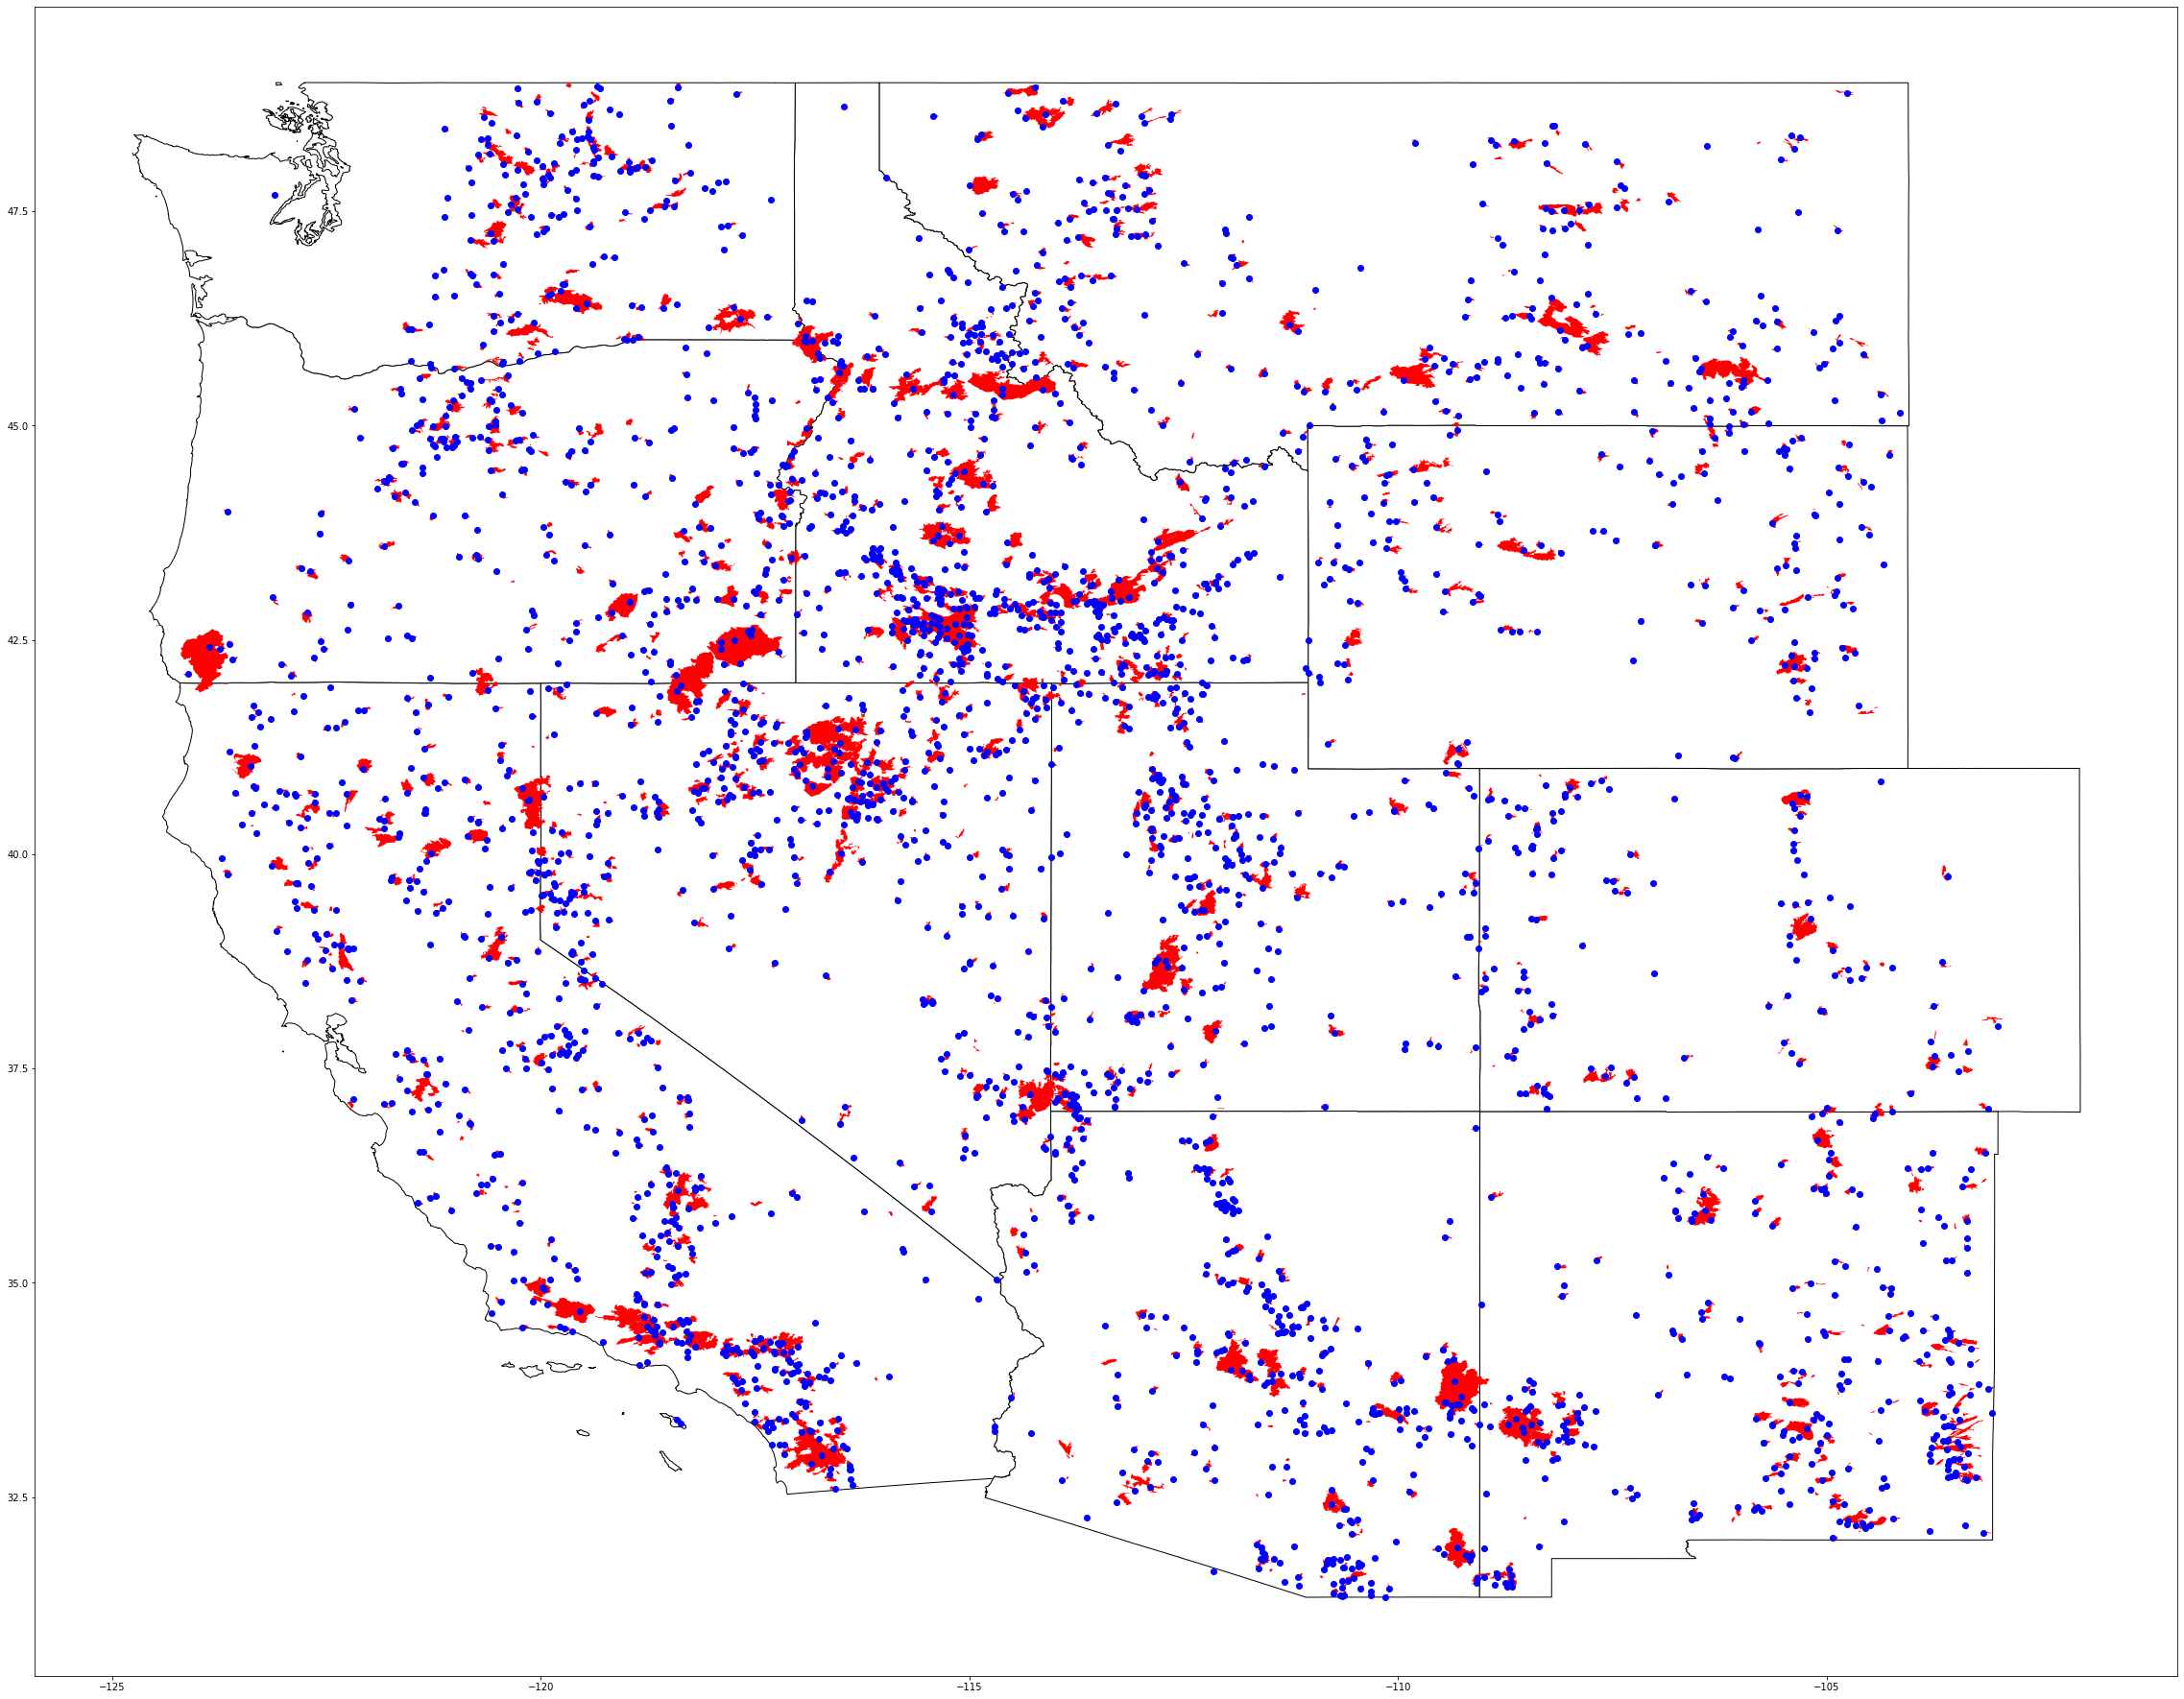

In [9]:
# Plot fire origins and perimeters
basemap = WestStates.plot(color = 'white', edgecolor = 'black')

# # Fire perimeters not matched to ICS forms
# West_MTBS.plot(ax=basemap,color='green')

# Fire perimeters
ICBS['geometry'] = ICBS['geometry_from_MTBS']
ICBS.plot(ax=basemap, color='red')

# Fire Point of Origins
ICBS['geometry'] = ICBS['geometry_from_ICS']
ICBS.plot(ax=basemap, color='blue')

In [10]:
# Project Fires into North American Equal area 2163
ICBS_proj = ICBS.copy()
WestStatesMap_proj = WestStates.to_crs("EPSG:2163")

# Project MTBS perimeters
ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()
ICBS_proj['geometry'] = ICBS_proj['geometry'].to_crs("EPSG:2163")
ICBS_proj['geometry_from_MTBS'] = ICBS_proj['geometry'].copy()

# Project ICS POO perimeter
ICBS_proj['geometry'] = ICBS_proj['geometry_from_ICS'].copy()
ICBS_proj = ICBS_proj.to_crs("EPSG:2163")
ICBS_proj['geometry_from_ICS'] = ICBS_proj['geometry'].copy()

In [11]:
## Select only fires with point of origin within 100 meters of final perimeter

ICBS_proj['geometry'] = ICBS_proj['geometry_from_MTBS'].copy()

def get_distance(row):
    distance = row.geometry.distance(row.geometry_from_ICS)
    return distance

ICBS_proj['POO_to_perim'] = ICBS_proj.apply(lambda row: get_distance(row), axis=1)

Fires = ICBS_proj.loc[(ICBS_proj['POO_to_perim'] <= 100)].copy() 
# Fires.POO_to_perim.describe()

In [12]:
## Create 40km buffer around origins

Firesgeo40km = Fires[['Fire_ID','geometry_from_MTBS','geometry_from_ICS','geometry']].copy()
Firesgeo40km['geometry'] = Firesgeo40km['geometry_from_ICS']
Firesgeo40km['geometry'] = Firesgeo40km.buffer(40000)

In [13]:
## Go to Zillow Data (unzipped)
## Set Directory
Zillowpath = '/data/yoder/ZillowAccessor_2001_2014/'
os.chdir(Zillowpath)

# Create Dictionary for State Abbreviations and Zillow numbers
States = {}
for p in glob.glob(Zillowpath+'*'):  
    try:
        df = pd.read_csv(p+'/ZAsmt\Main.txt', delimiter="|", header=None, nrows=10)
        States[p] = df.iloc[0,3]
#         print(p)
    except:
#         print("failed")
        pass
        
st = {value:key for key, value in States.items()}
# dict(sorted(st.items()))

In [14]:
## Create Dictionary of western States
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']
WestStatesList = [st[x] for x in st if x in West]
WestStatesDict = {x:st[x] for x in West}

Load Zillow lat long data

In [15]:
## Load All Zillow points takes __2600_____or 1940 about 1/2 hour_ california alone takes 1790
# start = time.time()

# Zillow = WestStatesDict.copy()
# for k, vi in Zillow.items():
#     filepi = open(f'{k}_pickle', 'rb')
#     Zillow[k] = pickle.load(filepi)
    
# end = time.time()
# print(end-start)

# subset = Zillow.copy()

In [16]:
## Takes 15 sec for 10k,  61 sec for 100k, 117 for 200k, 311 for 400k, 520 for 1 million


# def joiny(things_to_join, join_to):
#     return geopandas.sjoin(things_to_join, join_to, how='inner', op='intersects')

In [17]:
## with scattering 100k takes 320 sec
# for k, v in subset.items():
#     big_future = client.scatter(v)
#     subset[k] = dask.delayed(joiny)(big_future,Firesgeo40km)

In [18]:
## without scattering 100k takes 54 
# for k, v in subset.items():
#     subset[k] = dask.delayed(joiny)(v,Firesgeo40km)

In [19]:
## Results in a tuple with the dictionary first for results[0]['ID'] gives Idaho
# results = dask.compute(subset)

In [20]:
## Do california in series takes 16793 4.7 hours

# start = time.time()
# Merged_CA = geopandas.sjoin(CA, Firesgeo40km, how='inner', op='intersects')

# end = time.time()
# print(end-start)

In [21]:
###################
### Save all but CA joined data to pickle takes 1078 sec
#################
## Save as pickle 

# start = time.time()
# for k, v in results[0].items():
#     filehand = open(f'{k}_joined_pickle', 'wb')
#     pickle.dump(v, filehand)
# end = time.time()
# print(end-start)

#################
## Save CA takes 2918
#################
# start = time.time()
# filehand = open('CA_joined_pickle', 'wb')
# pickle.dump(Merged_CA, filehand)
# end = time.time()
# print(end-start)

In [22]:
# # Create dictionary from list
# Zmerged = {i :1 for i in West}

Open Zillow Data joined to Fire buffers

In [23]:
# Read in series takes 2498 sec 41 min
# WA
# 57.14106845855713
# OR
# 62.94558382034302
# CA
# 1537.6975452899933
# NV
# 137.16192817687988
# AZ
# 360.31261229515076
# NM
# 34.34808325767517
# UT
# 116.77999472618103
# CO
# 273.70055198669434
# WY
# 10.977016687393188
# ID
# 79.87886571884155
# MT
# 47.37062954902649
# 2718.31582736969

# start = time.time()

# Zmerged = {i : 1  for i in West}
# for k, v in Zmerged.items():
#     step1 = time.time()
#     print(k)
#     filepi = open(f'/data/yoder/ZillowAccessor_2001_2014/{k}_joined_pickle', 'rb')
#     Zmerged[k] = pickle.load(filepi)
#     step2 = time.time()
#     print(step2-step1)

# end = time.time()
# print(end-start)

Get distance to perimeter and origin

In [24]:
# subset = Zmerged.copy()
## Remove out long running files
# del subset['CA']
# del subset['CO']
# del subset['AZ']

In [25]:
# subset.keys()

In [29]:
## Define function to get distance from Zillow to fire perimeter
def get_dist_perim(row):
    distance = row.geometry.distance(row.geometry_from_MTBS)
    return distance

## Define function to get distance from Zillow to ICS Point of origin (POO)
def get_dist_origin(row):
    distance = row.geometry.distance(row.geometry_from_ICS)
    return distance

In [30]:
1+1

2

In [31]:
###################################################
## Get distances to origin for California
###################################################


filep = open('/data/yoder/ZillowAccessor_2001_2014/CA_joined_pickle','rb')
%time CA = pickle.load(filep)



CPU times: user 23min 51s, sys: 54.6 s, total: 24min 46s
Wall time: 26min 15s


In [ ]:
# takes 77911
start=time.time()
CA['dist_to_origin'] = CA.apply(lambda row: get_dist_origin(row), axis = 1)
end=time.time()
print(end-start)
print('Got Dist to Origin')

filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/WithDist/CA_origin_dist','wb')
pickle.dump(CA,filehand)


print('Started_perim')
start = time.time()
print(start)

CA['dist_to_perim'] = CA.apply(lambda row: get_dist_perim(row), axis = 1)
end = time.time()
print(end-start)
print('Only saving left')
filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/WithDist/CA_dist','wb')
pickle.dump(CA,filehand)
print('DID IT!!!')

74524.18644547462
Got Dist to Origin
Started_perim
1589953609.1519675


1+1

In [27]:
###################################################
## Get distances to origin
###################################################
## Without AZ, CA, CO takes 23979 ~ 6.6 hours


# WA
# 1725.6317582130432
# OR
# 1915.3105800151825
# NV
# 4970.134178876877
# NM
# 883.5174057483673
# UT
# 7340.241145372391
# WY
# 218.5449686050415
# ID
# 5010.421579837799
# MT
# 1915.9086017608643
# 23979.7123169899

# start = time.time()
# for k, v in subset.items():
#     print(f'{k}')
#     step1 = time.time()
#     subset[k]['dist_to_origin'] = subset[k].apply(lambda row: get_dist_origin(row), axis = 1)
#     step2 = time.time()
#     print(step2-step1)
# end = time.time()
# print(end-start)

In [28]:
###################################################
## Get distances to perimeters
###################################################
# ## Without AZ, CA, CO takes 33849 ~9.4 hours

# start = time.time()
# for k, v in subset.items():
#     print(f'{k}')
#     step1 = time.time()
#     subset[k]['dist_to_perim'] = subset[k].apply(lambda row: get_dist_perim(row), axis = 1)
#     step2 = time.time()
#     print(step2-step1)
# end = time.time()
# print(end-start)

In [29]:
###################################################
## Do everything for AZ and CO takes 12.4 hours
###################################################
# withAZCO = {i : 1  for i in West}
# keys_to_remove = ['CA','WA', 'OR', 'NV', 'NM', 'UT', 'WY', 'ID', 'MT']
# for key in keys_to_remove:
#   del withAZCO[key]
# for k, v in withAZCO.items():
#     step1 = time.time()
#     print(k)
#     filepi = open(f'/data/yoder/ZillowAccessor_2001_2014/{k}_joined_pickle', 'rb')
#     withAZCO[k] = pickle.load(filepi)
#     step2 = time.time()
#     print(step2-step1)
# AZ
# 270.8557765483856
# CO
# 240.8402919769287

######################### Get Distance to origin

# start = time.time()
# for k, v in withAZCO.items():
#     print(f'{k}')
#     step1 = time.time()
#     withAZCO[k]['dist_to_origin'] = withAZCO[k].apply(lambda row: get_dist_origin(row), axis = 1)
#     step2 = time.time()
#     print(step2-step1)
# end = time.time()
# print(end-start)
# AZ
# 9328.36432647705
# CO
# 7886.695660114288
# 17215.06111764908

######################### Get Distance to perim
# start = time.time()
# for k, v in withAZCO.items():
#     print(f'{k}')
#     step1 = time.time()
#     withAZCO[k]['dist_to_perim'] = withAZCO[k].apply(lambda row: get_dist_perim(row), axis = 1)
#     step2 = time.time()
#     print(step2-step1)
# end = time.time()
# print(end-start)

# AZ
# 13895.530579328537
# CO
# 12131.269798994064
# 26026.801690340042

# # Save with distance and geometry as pickle takes ______
# start = time.time()
# for k, v in withAZCO.items():
#     filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/WithDist/{k}_dist','wb')
#     pickle.dump(v,filehand)

# end = time.time()
# print(end-start)
# 868 sec

In [31]:
## Save with distance and geometry as pickle takes 914 sec ~15 min
# start = time.time()
# for k, v in tosave.items():
#     filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/WithDist/{k}_dist','wb')
#     pickle.dump(v,filehand)

# end = time.time()
# print(end-start)

In [32]:
# start = time.time()
# for k, v in tosave.items():
#     filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/justdist/{k}_dist','wb')
#     pickle.dump(v,filehand)
# end = time.time()
# print(end-start)

In [44]:
AZ = withAZCO['AZ'].drop(['geometry','geometry_from_MTBS','geometry_from_ICS'], axis=1)

In [56]:
CO = withAZCO['CO'].drop(['geometry','geometry_from_MTBS','geometry_from_ICS'], axis=1)

In [46]:
filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/justdist/AZ_dist','wb')
pickle.dump(AZ, filehand)

In [57]:
filehand = open(f'/data/yoder/ZillowAccessor_2001_2014/justdist/CO_dist','wb')
pickle.dump(CO, filehand)

In [55]:
CO

,RowID,index_right,Fire_ID,dist_to_origin,dist_to_perim
0,1AE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,38443.575831,35398.951155
1,1CE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39245.570676,36181.189555
2,1DE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39337.234230,36273.513902
3,1EE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39411.183904,36345.958390
4,1FE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,38398.665629,35354.762057
...,...,...,...,...,...
18904359,019368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,36614.727802,32601.825563
18904362,109368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,37473.217477,33448.199863
18904363,409368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,38673.786667,34747.846400
18904364,429368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,39422.228374,35546.284369


In [63]:
##############################################
###   Load in distance data
###
##############################################

## Load Zillow with distances (no CA,CO, AZ) takes 23 seconds
Sample = {i : 1  for i in West}
del Sample['CA']
# del Sample['CO']
# del Sample['AZ']

start = time.time()

for k, v in Sample.items():
#     step1 = time.time()
#     print(k)
    filepi = open(f'/data/yoder/ZillowAccessor_2001_2014/justdist/{k}_dist','rb')
    Sample[k] = pickle.load(filepi)
#     step2 = time.time()
#     print(step2-step1)
print(time.time()-start)

31.31378483772278


In [61]:
df = pd.read_pickle('/data/yoder/ZillowAccessor_2001_2014/justdist/AZ_dist')

In [62]:
df

,RowID,index_right,Fire_ID,dist_to_origin,dist_to_perim
0,E07B2C56-39D5-E511-80C1-3863BB43AC67,148,AZ3387810932020040608,28226.677237,22396.853808
1,EE7B2C56-39D5-E511-80C1-3863BB43AC67,148,AZ3387810932020040608,29228.809605,22798.627972
2,8B7C2C56-39D5-E511-80C1-3863BB43AC67,148,AZ3387810932020040608,27203.872398,21389.691924
3,93842C56-39D5-E511-80C1-3863BB43AC67,148,AZ3387810932020040608,28000.280716,22141.894675
4,E9862C56-39D5-E511-80C1-3863BB43AC67,148,AZ3387810932020040608,28702.265888,22574.724374
...,...,...,...,...,...
21079094,BE28C982-C9D5-E511-80C1-3863BB43AC67,209,AZ3464111299420050717,39865.309172,33254.008606
21079095,BF28C982-C9D5-E511-80C1-3863BB43AC67,209,AZ3464111299420050717,39869.194541,33256.726850
21079096,C028C982-C9D5-E511-80C1-3863BB43AC67,209,AZ3464111299420050717,39873.082625,33259.448581
21079118,D928C982-C9D5-E511-80C1-3863BB43AC67,209,AZ3464111299420050717,39954.432657,33345.101722


In [60]:
df

,RowID,index_right,Fire_ID,dist_to_origin,dist_to_perim
0,1AE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,38443.575831,35398.951155
1,1CE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39245.570676,36181.189555
2,1DE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39337.234230,36273.513902
3,1EE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,39411.183904,36345.958390
4,1FE6A676-31D5-E511-80C1-3863BB43AC67,834,CO3940010473020110324,38398.665629,35354.762057
...,...,...,...,...,...
18904359,019368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,36614.727802,32601.825563
18904362,109368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,37473.217477,33448.199863
18904363,409368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,38673.786667,34747.846400
18904364,429368DB-D0D5-E511-80C1-3863BB43AC67,885,CO4083210437120011107,39422.228374,35546.284369


In [119]:
AllDists =  pd.DataFrame()
for k, v in Sample.items():
    AllDists = pd.concat([AllDists, v])

In [158]:
AllDists

,RowID,Fire_ID,dist_to_origin,dist_to_perim
0,4B207BB1-28D5-E511-80C1-3863BB43AC67,WA4757911843020050727,38612.077209,37507.683826
2661,55337BB1-28D5-E511-80C1-3863BB43AC67,WA4757911843020050727,34176.244783,33116.007439
2667,61337BB1-28D5-E511-80C1-3863BB43AC67,WA4757911843020050727,33599.340530,32426.418336
2673,80337BB1-28D5-E511-80C1-3863BB43AC67,WA4757911843020050727,36409.604051,35017.205518
2680,90337BB1-28D5-E511-80C1-3863BB43AC67,WA4757911843020050727,33599.340530,32426.418336
...,...,...,...,...
2138707,79935F72-58D5-E511-80C1-3863BB43AC67,MT4780011318420120909,39217.862921,33685.316386
2138708,7B935F72-58D5-E511-80C1-3863BB43AC67,MT4780011318420120909,39023.957627,33492.311342
2138709,7C935F72-58D5-E511-80C1-3863BB43AC67,MT4780011318420120909,39211.675439,33679.709101
2599167,B5C6610A-9FD5-E511-80C1-3863BB43AC67,MT4780011318420120909,38897.081924,33364.517761


In [63]:
# start = time.time()
# Dists['dist_to_origin'].describe().compute()
# end = time.time()
# print(end-start)

In [70]:
for k, v in Sample.items():
    Sample[k]['reached'] = np.where(Sample[k]['dist_to_perim'] <=30, 1, 0 )

In [71]:
Bhomes = Sample.copy()
for k, v in Sample.items():
    Bhomes[k] = Sample[k].loc[Sample[k]['reached'] ==1]

In [75]:
merged_df = pd.DataFrame()
for k, v in Bhomes.items():
    merged_df = pd.concat([merged_df, v])

In [106]:
merged_df['dist_to_origin'].describe(percentiles=[.25, .5, .75, .90, .95, .955, .96])

count    76243.000000
mean      7343.903801
std       7223.173943
min          6.119294
25%       2871.380611
50%       6013.210014
75%       9234.860264
90%      13358.040779
95%      17216.499815
95.5%    18436.062486
96%      21499.301343
max      39966.088197
Name: dist_to_origin, dtype: float64

In [110]:
Allhomes = pd.DataFrame()
for k, v in Sample.items():
    Allhomes = pd.concat([Allhomes, v])

In [113]:
Allhomes['dist_to_origin'].describe()

count    2.384928e+08
mean     2.802197e+04
std      8.650677e+03
min      6.119294e+00
25%      2.216217e+04
50%      2.951581e+04
75%      3.533046e+04
max      3.999987e+04
Name: dist_to_origin, dtype: float64

In [120]:
Allhomes['dist_to_origin'].describe(percentiles=[.25, .5, .75, .90, .95, .99])

count    2.384928e+08
mean     2.802197e+04
std      8.650677e+03
min      6.119294e+00
25%      2.216217e+04
50%      2.951581e+04
75%      3.533046e+04
90%      3.822839e+04
95%      3.909531e+04
99%      3.979605e+04
max      3.999987e+04
Name: dist_to_origin, dtype: float64

In [123]:
Allhomes.memory_usage()/1e9

Index             1.907943
RowID             1.907943
Fire_ID           1.907943
dist_to_origin    1.907943
dist_to_perim     1.907943
reached           1.907943
index_right       1.907943
dtype: float64

In [124]:
Allhomes.to_parquet('/data/yoder/DensityProject/Structures/Distances.parquet')

Text(0.5, 0, 'Distance from Origin (meters)')

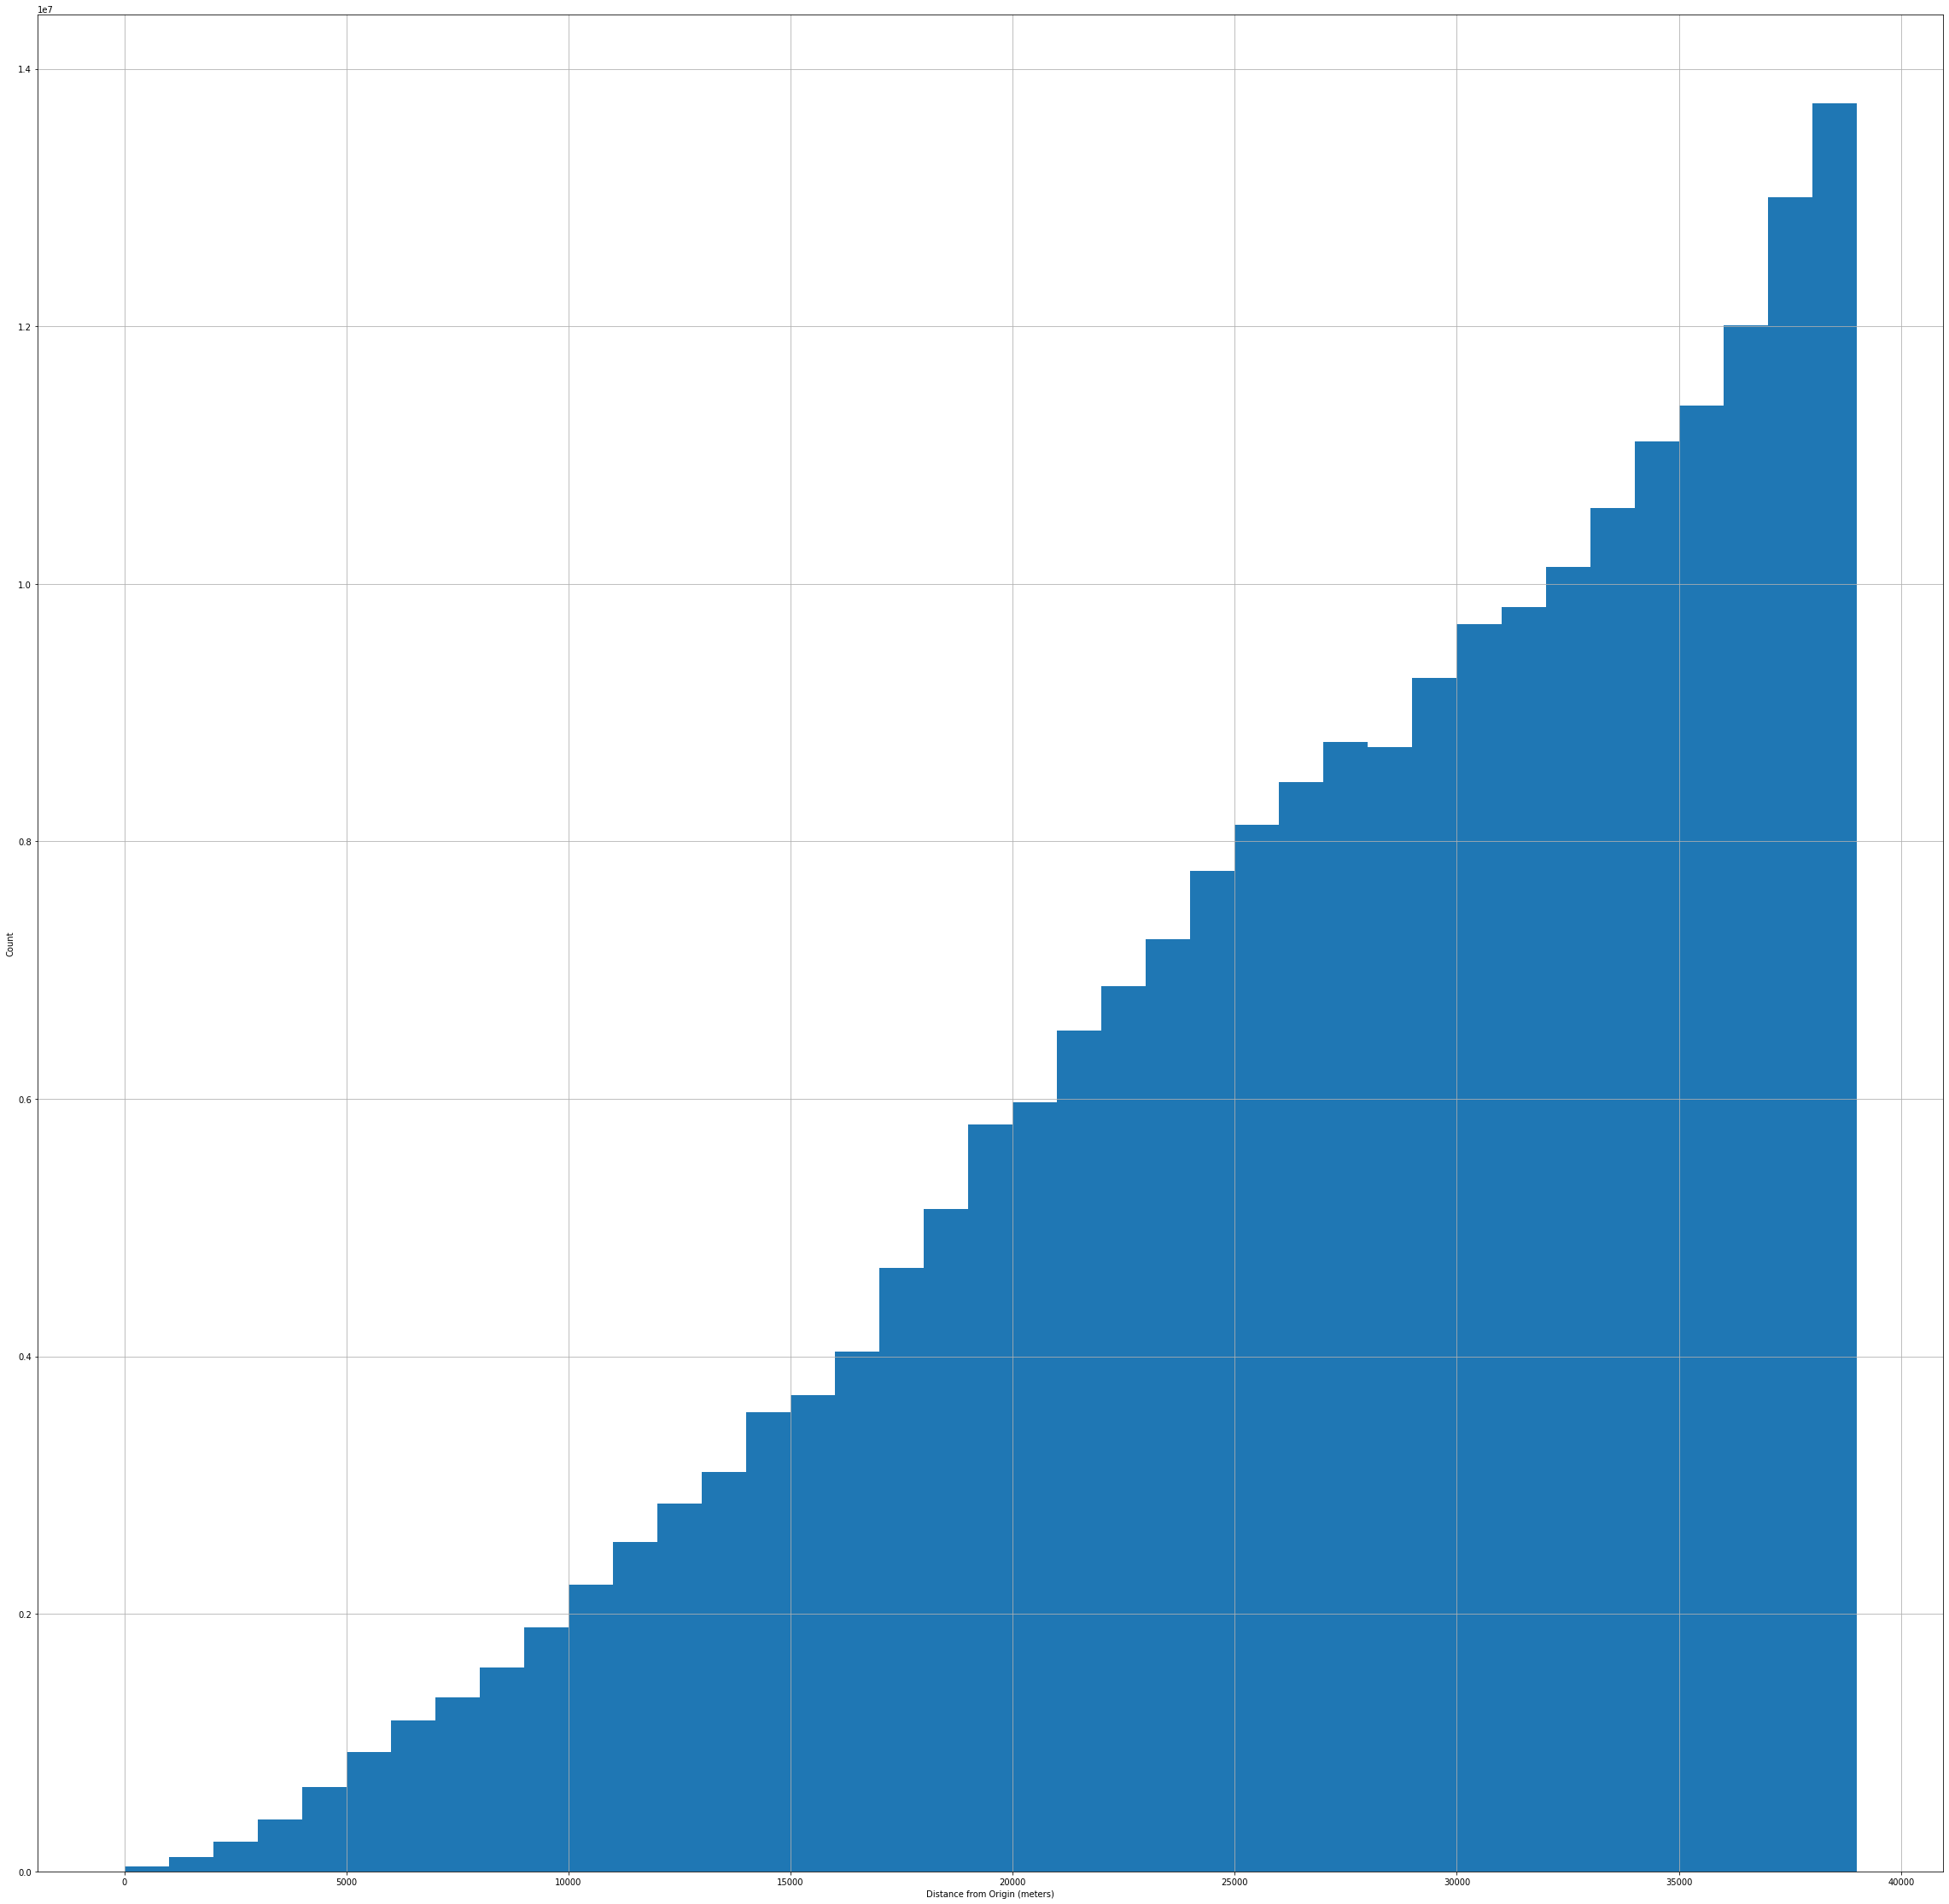

In [121]:
Allhomes['dist_to_origin'].hist(bins = range(0,40000,1000))

plt.ylabel('Count')
plt.xlabel('Distance from Origin (meters)')

In [107]:
merged_df['dist_to_perim'].describe(percentiles=[.25, .5, .75, .90, .95, .955, .96])

count    76243.000000
mean         1.832614
std          5.821796
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          5.008740
95%         17.833348
95.5%       19.175402
96%         20.618461
max         29.990635
Name: dist_to_perim, dtype: float64

In [ ]:
# # For distance <=0
# count    25083.000000
# mean      6129.960469
# std       6132.600668
# min         29.728731
# 25%       2326.675435
# 50%       3965.637287
# 75%       9135.510992
# max      39859.777290
# Name: dist_to_origin, dtype: float64

# For distance <=0
# count    31177.000000
# mean      5775.204439
# std       6049.934776
# min          6.119294
# 25%       2159.869697
# 50%       3676.245828
# 75%       8794.453131
# max      39859.777290
# Name: dist_to_origin, dtype: float64

# # For distance <= 100
# count    49269.000000
# mean      5116.206041
# std       5994.767894
# min          6.119294
# 25%       1651.110264
# 50%       2993.868078
# 75%       6322.358243
# max      39859.777290
# Name: dist_to_origin, dtype: float64
        
# # For Distance <=120     
# count    55127.000000
# mean      4934.157302
# std       5903.822036
# min          6.119294
# 25%       1477.953540
# 50%       2869.781856
# 75%       5838.741208
# max      39859.777290
# Name: dist_to_origin, dtype: float64

In [84]:
# %matplotlib inline
# width = 20
# height = 0
# plt.rcParams['figure.figsize'] = [width, height]

Text(0.5, 0, 'Distance from Origin (meters)')

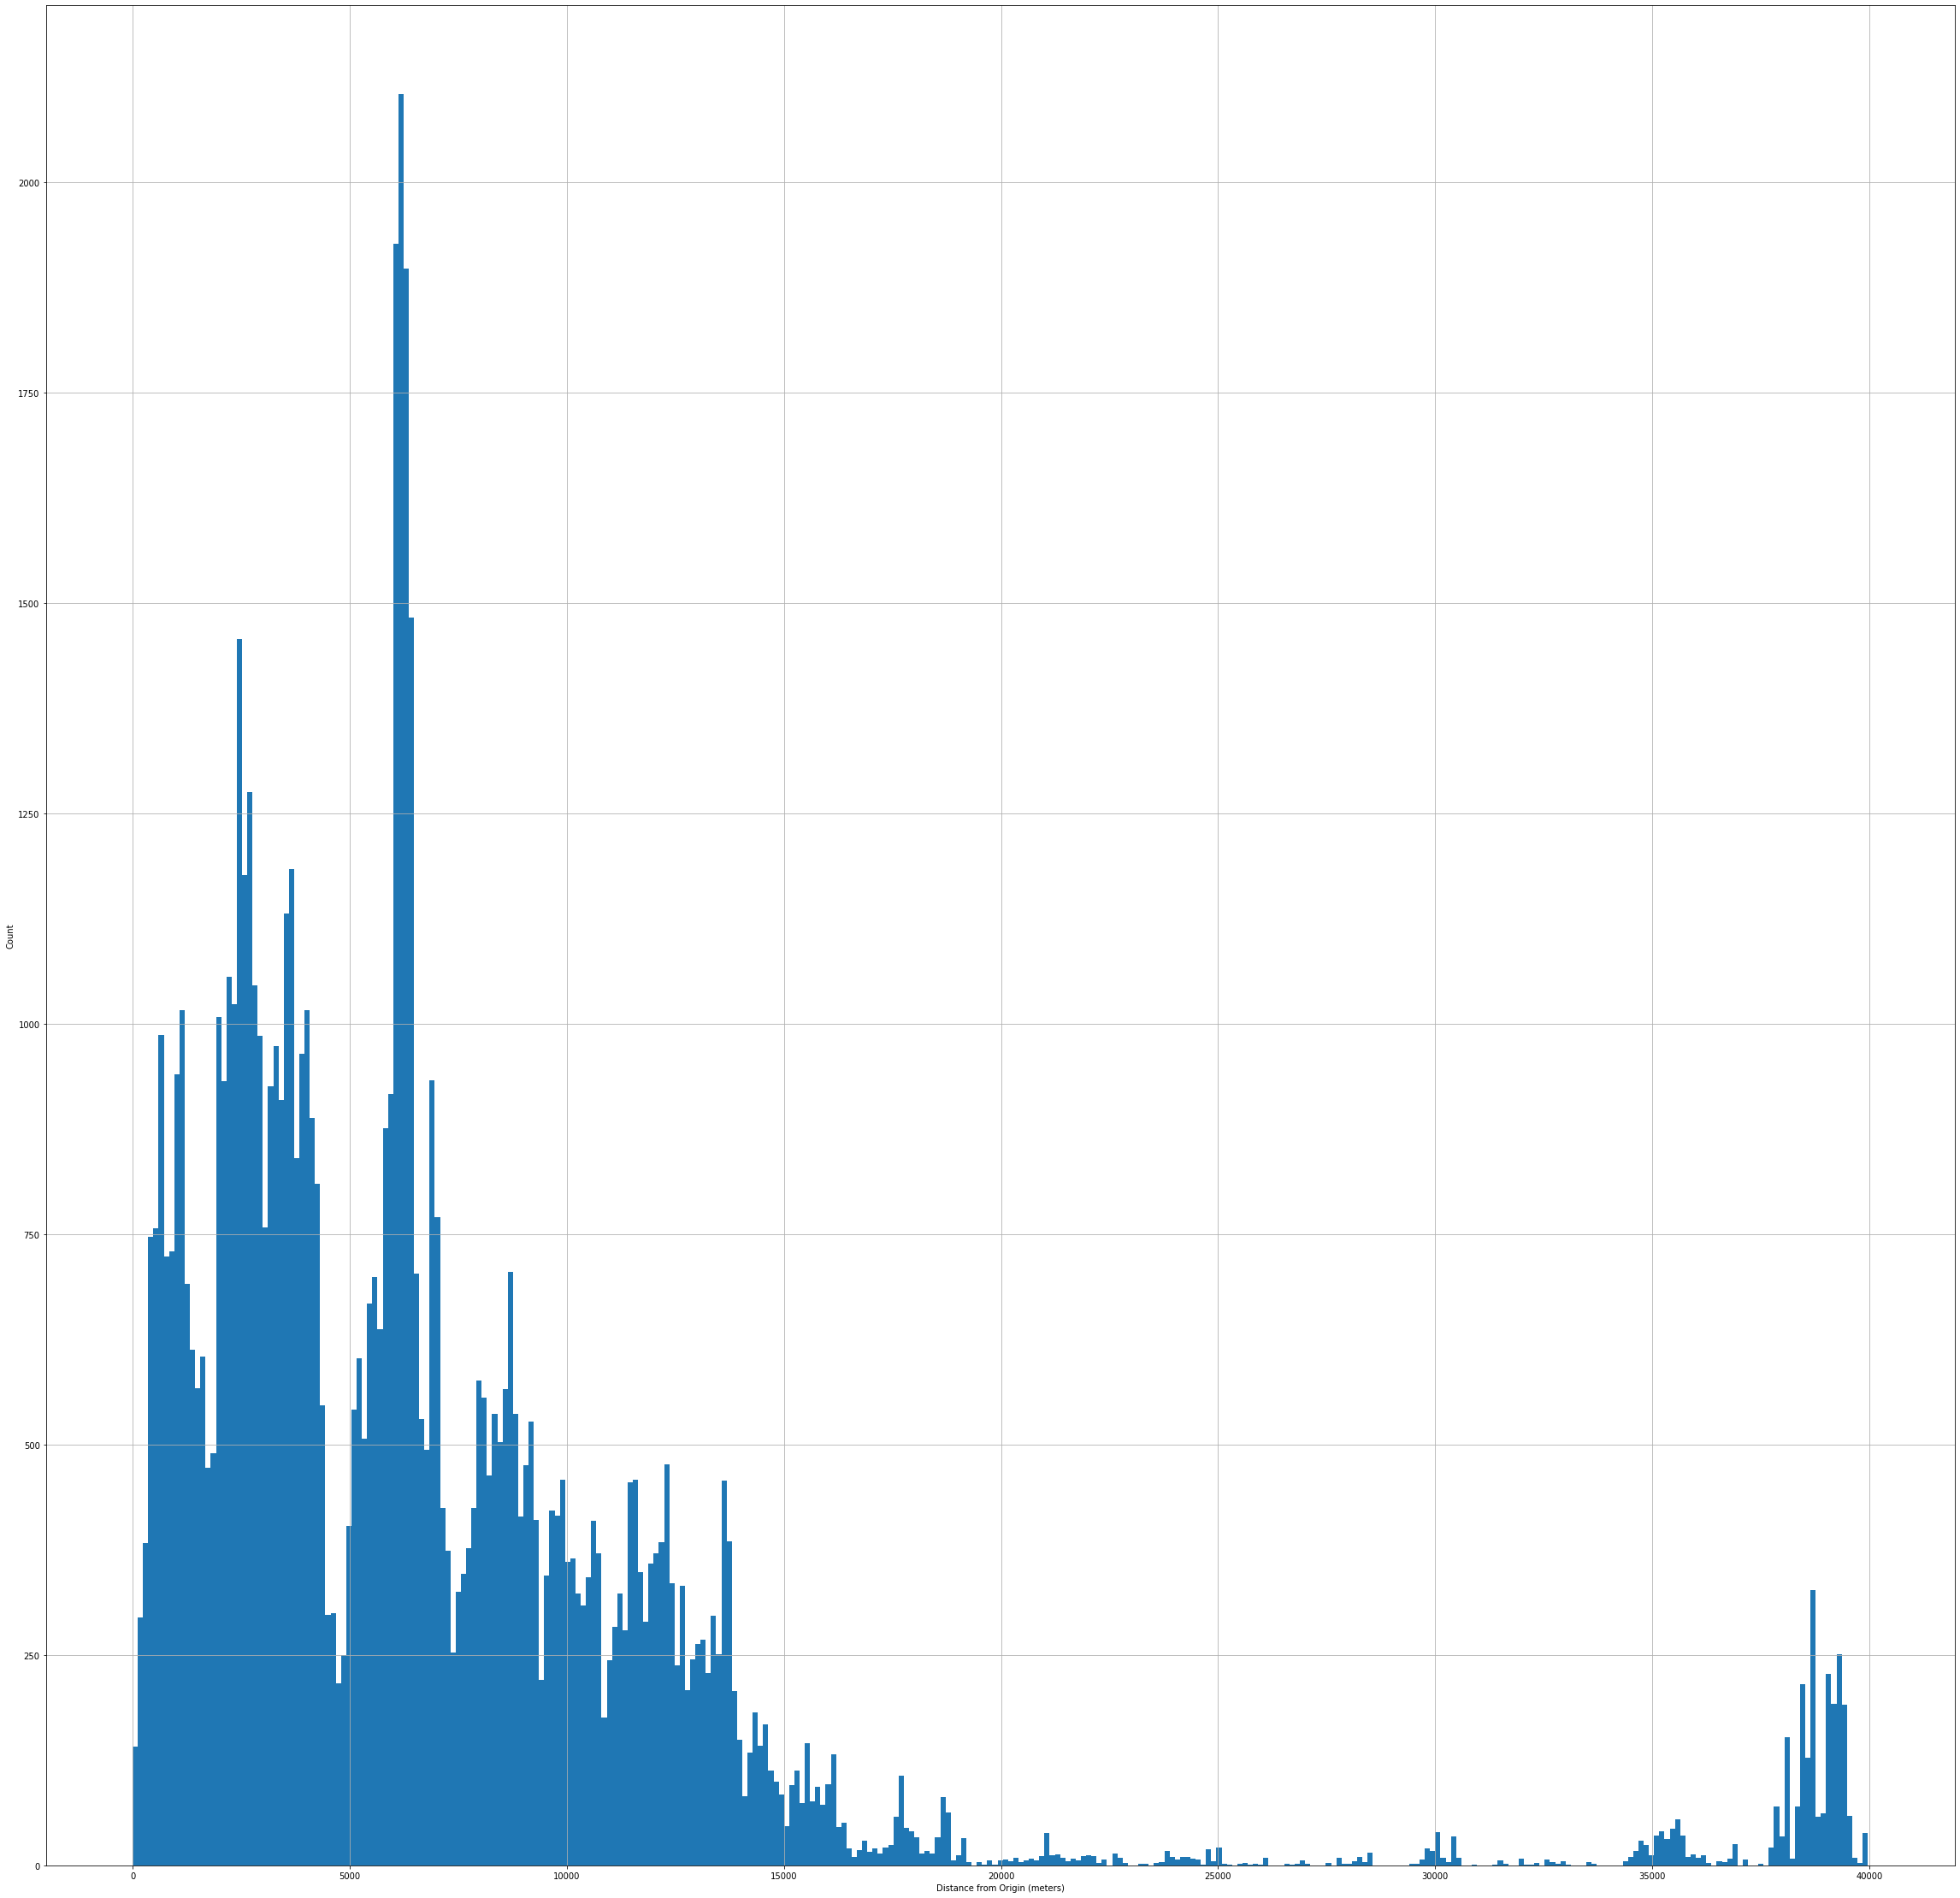

In [92]:
merged_df['dist_to_origin'].hist(bins = range(0,40000,120))

plt.ylabel('Count')
plt.xlabel('Distance from Origin (meters)')

Text(0.5, 0, 'Distance from Origin (meters)')

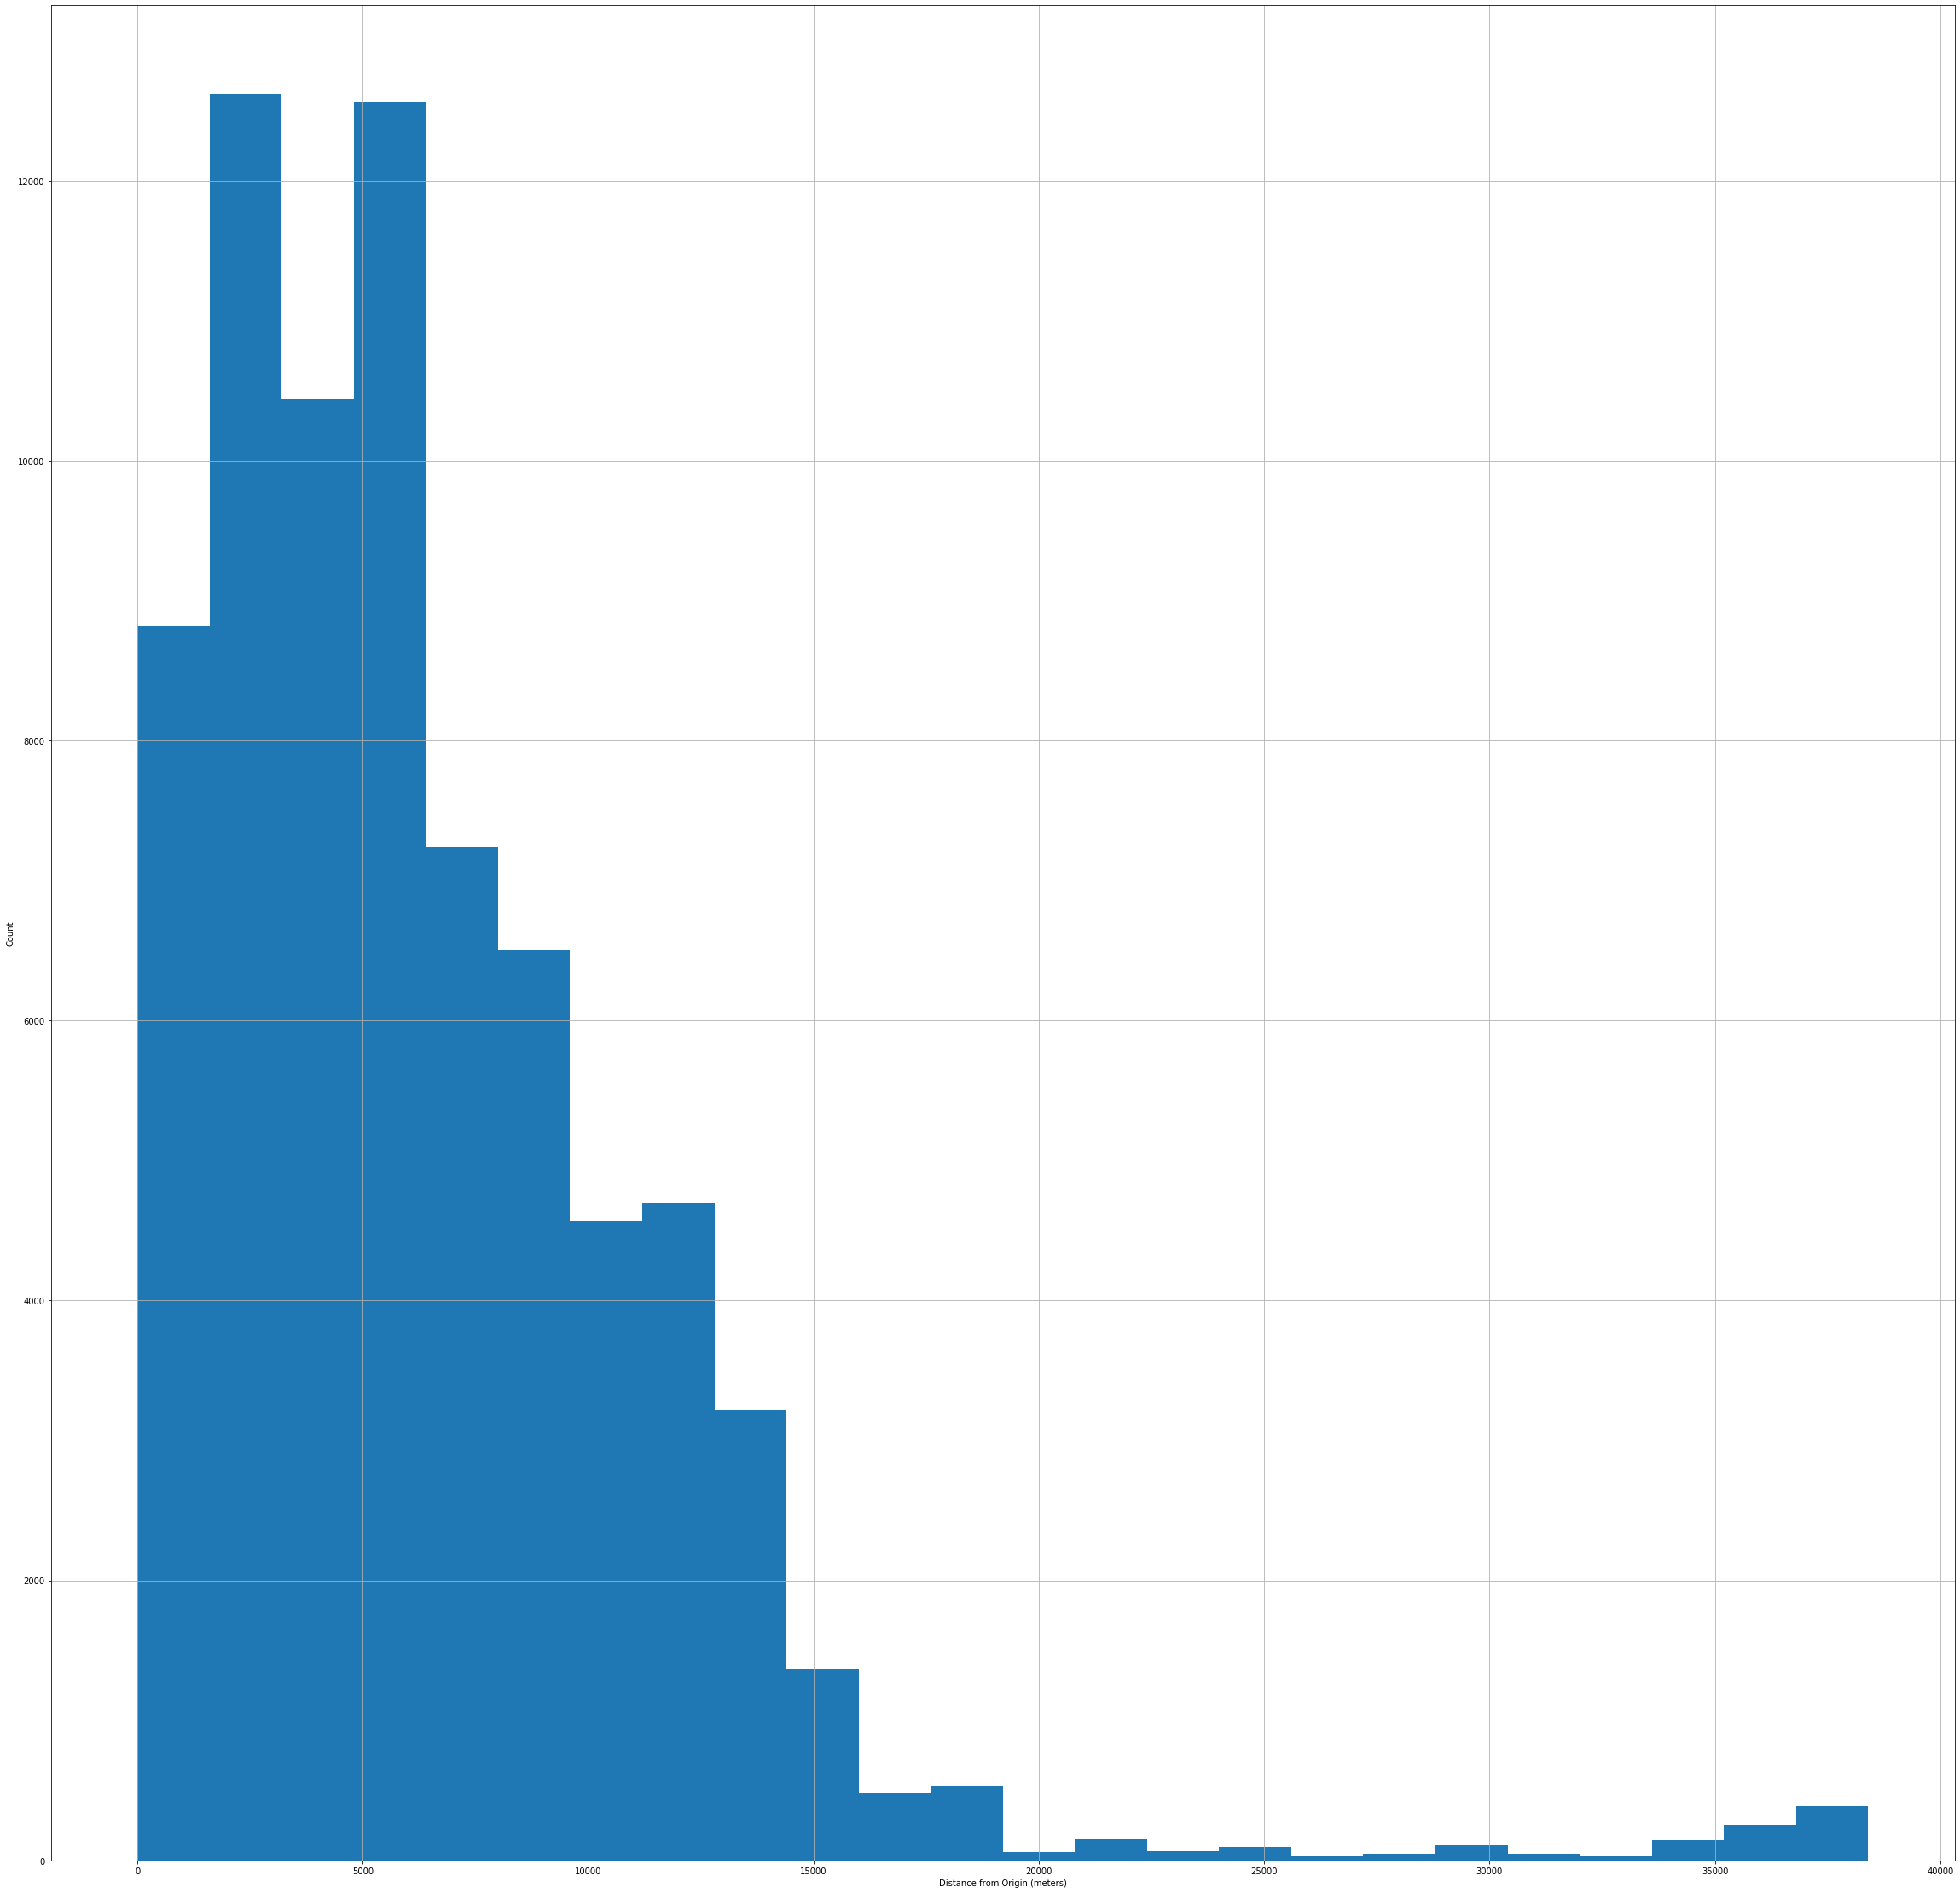

In [88]:
merged_df['dist_to_origin'].hist(bins = range(0,40000,1600))

plt.ylabel('Count')
plt.xlabel('Distance from Origin (meters)')

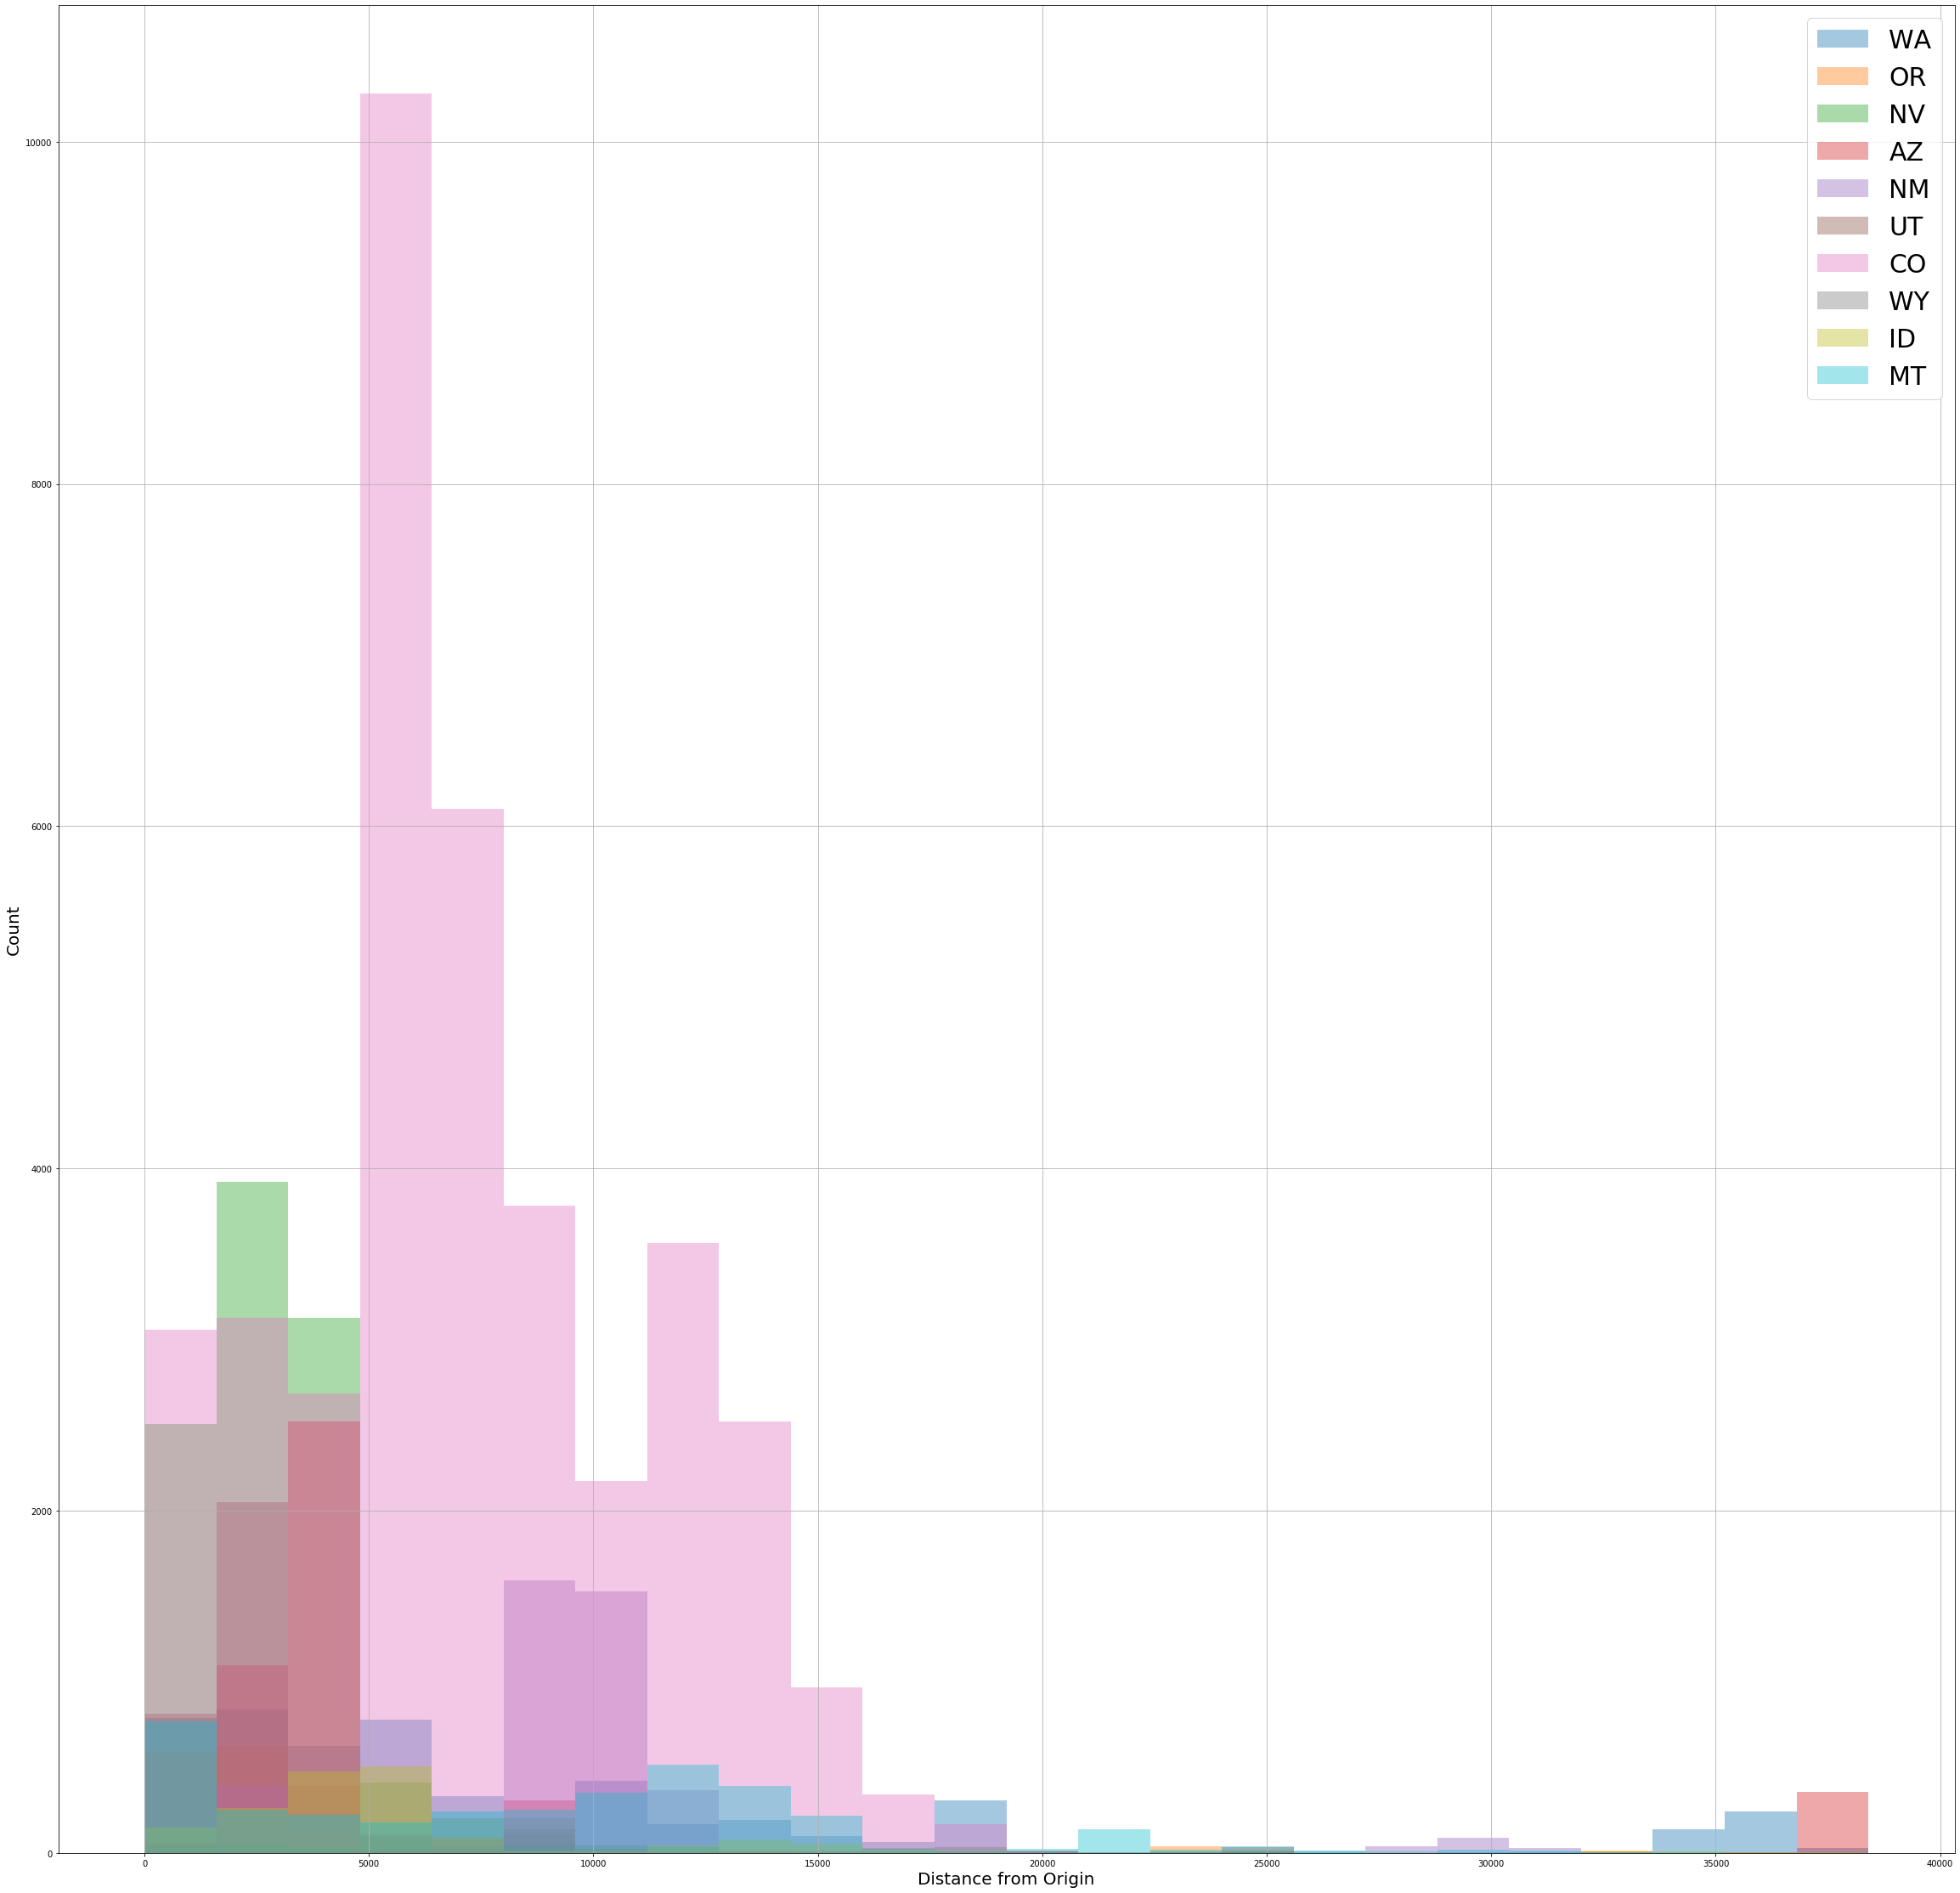

In [87]:
home = pd.DataFrame()

for k, v in Bhomes.items():
    Bhomes[k]['dist_to_origin'].hist(bins = range(0,40000,1600) ,label=k, alpha=0.4)
#     plt.show()
plt.legend(fontsize=30)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Distance from Origin',fontsize=20)
plt.show()